In [1]:
import torch
# import nn as nn
# import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import burst_detector as bd
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
from torch.profiler import profile, record_function, ProfilerActivity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import scipy.spatial.distance as dist
from sklearn.neighbors import NearestNeighbors

### Loading dataset + function definitions

In [2]:
n_chan = 385

ks_dir = "../data/rec_bank0_dense_g0/KS2.5/catgt_rec_bank0_dense_g0/rec_bank0_dense_g0_imec0/imec0_ks2/"

times = np.load(os.path.join(ks_dir, "spike_times.npy")).flatten()
clusters = np.load(os.path.join(ks_dir, "spike_clusters.npy")).flatten()

counts = bd.spikes_per_cluster(clusters)
cl_labels = pd.read_csv(os.path.join(ks_dir, "cluster_group.tsv"), sep="\t", index_col=False)
times_multi = bd.find_times_multi(times, clusters, np.arange(clusters.max()+1))

channel_pos = np.load(os.path.join(ks_dir, "channel_positions.npy"))
channel_map = np.load(os.path.join(ks_dir, "channel_map.npy")).flatten()
mean_wf = np.load(os.path.join(ks_dir, "mean_waveforms.npy"))
peak_chans = np.argmax(np.max(mean_wf, 2) - np.min(mean_wf,2),1)

channel_shanks = (channel_pos[:,0]/250).astype("int")
templates = np.load(os.path.join(ks_dir, "templates.npy"))

# load raw data
rawData = np.memmap("C:/Users/Harris_Lab/Projects/burst-detector/data/rec_bank0_dense_g0/KS2.5/catgt_rec_bank0_dense_g0/rec_bank0_dense_g0_imec0/rec_bank0_dense_g0_tcat.imec0.ap.bin", dtype='int16', mode='r')
data = np.reshape(rawData, (int(rawData.size/n_chan), n_chan))

In [3]:
def get_closest_channels(channel_positions, channel_index, n=None):
    """Get the channels closest to a given channel on the probe."""
    x = channel_positions[:, 0]
    y = channel_positions[:, 1]
    x0, y0 = channel_positions[channel_index]
    d = (x - x0) ** 2 + (y - y0) ** 2
    out = np.argsort(d)
    if n:
        out = out[:n]
    return out

In [4]:
def find_best_channels(template):
    amplitude_threshold = 0
    
    amplitude = template.max(axis=1) - template.min(axis=1)
    best_channel = min(np.argmax(amplitude), 382)
    max_amp = amplitude[best_channel]
    
    peak_channels = np.nonzero(amplitude >= amplitude_threshold * max_amp)[0]
    
    close_channels = get_closest_channels(channel_pos, best_channel, 8)

    shank = channel_shanks[best_channel]
    channels_on_shank = np.nonzero(channel_shanks == shank)[0]
    close_channels = np.intersect1d(close_channels, channels_on_shank)
    channel_ids = np.intersect1d(close_channels, peak_channels)
    
    return channel_ids, best_channel

In [5]:
def get_dists(channel_positions, ref_chan, target_chan):
    x = channel_positions[:, 0]
    y = channel_positions[:, 1]
    x0, y0 = channel_positions[ref_chan]
    d = (x - x0) ** 2 + (y - y0) ** 2
    # d[y < y0] *= -1
    return d[target_chan]

In [6]:
chans = {}

for i in range(mean_wf.shape[0]):
    if i in counts:
        chs, peak = find_best_channels(mean_wf[i])
        dists = get_dists(channel_pos, peak, chs)
        chans[i] = chs[np.argsort(dists)].tolist()

### Latent representation calculation

In [7]:
# load dataset and pre-trained model
spk_data = bd.autoencoder.SpikeDataset("./data/bijan_spikes/labels.csv","./data/bijan_spikes/", ToTensor())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = bd.autoencoder.CN_AE().to(device)
net.load_state_dict(torch.load('./models/bijan_vn_15d_balanced.pt'))
net.eval();

In [8]:
# calculate latent representation of spikes
BATCH_SIZE = 128

labels = spk_data.spk_labels.iloc[:, 1]

# generate indices: instead of the actual data we pass in integers instead
train_indices, test_indices, _, _ = train_test_split(
    range(len(spk_data)),
    labels,
    stratify=labels,
    test_size=0.2,
    random_state=42
)

# generate subset based on indices
train_split = Subset(spk_data, train_indices)
train_loader = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True)

train_lat = np.zeros((len(train_indices), 15))
train_lab = np.zeros(len(train_indices))

with torch.no_grad():
    for idx, data in enumerate(train_loader, 0):
        print("\r" + str(idx), end="")
        imgs, lab = data
        imgs = imgs.to(device)
        
        out = net.encoder(imgs)
        train_lat[128*idx:(idx+1)*128,:] = out.cpu().detach().numpy()
        train_lab[128*idx:(idx+1)*128] = lab.cpu().detach().numpy()

1253

In [9]:
# construct dataframes w/peak channel
ae_df = pd.DataFrame({'cl': train_lab})
for i in range(ae_df.shape[0]):
    ae_df.loc[i, 'peak'] = chans[ae_df.loc[i, 'cl']][0]
train_lat_peak = np.hstack((train_lat, np.expand_dims(np.array(ae_df['peak']), 1))) 

# calculate cluster centroids
lat_df = pd.DataFrame(train_lat_peak)
lat_df['cl'] = ae_df['cl']
lat_mean = np.zeros((mean_wf.shape[0], 16))
for group in lat_df.groupby('cl'):
    lat_mean[int(group[0]), :] = group[1].iloc[:,:16].mean(axis=0)

lat_dist = np.vstack((train_lat_peak, lat_mean))

### Autoencoder similarity metric

In [10]:
# calculate nearest neighbors, pairwise distances for cluster centroids
neigh = NearestNeighbors(n_neighbors=100, metric='euclidean').fit(lat_mean[:,:15])
dists, neighbors = neigh.kneighbors(lat_mean[:,:15], return_distance=True)
ae_dist = dist.squareform(dist.pdist(lat_mean[:,:15], 'euclidean'))

# similarity threshold for further analysis -- mean + std of distance to 1st NN
ref_dist = dists[dists[:,1] != 0, 1].mean() + dists[dists[:,1] != 0, 1].std()

In [11]:
# calculate similarity
ae_sim = np.exp(-0.5*ae_dist/ref_dist)

# ignore self-similarity
for i in range(ae_dist.shape[0]):
    ae_sim[i,i] = 0
    
# ignore low-spike and noise clusters
for i in range(ae_dist.shape[0]):
    if (i not in counts) or (counts[i] < 100) or (cl_labels.loc[cl_labels['cluster_id']==i, 'group'].item() != 'good'):
        ae_sim[i, :] = 0
        ae_sim[:, i] = 0

In [12]:
# penalize pairs with different peak channels
amps = np.max(mean_wf, 2) - np.min(mean_wf,2)

for i in range(ae_dist.shape[0]):
    for j in range(i, ae_dist.shape[0]):
        if (i in counts) and (j in counts):
            p1 = peak_chans[i]; p2 = peak_chans[j];
            
            # penalize by decay 
            ae_sim[i,j] *= np.sqrt(amps[i, p2]/amps[i, p1]*amps[j, p1]/amps[j, p2])
            ae_sim[j,i] = ae_sim[i,j]
        
        else:
            ae_sim[i,j] = 0
            ae_sim[j,i] = 0

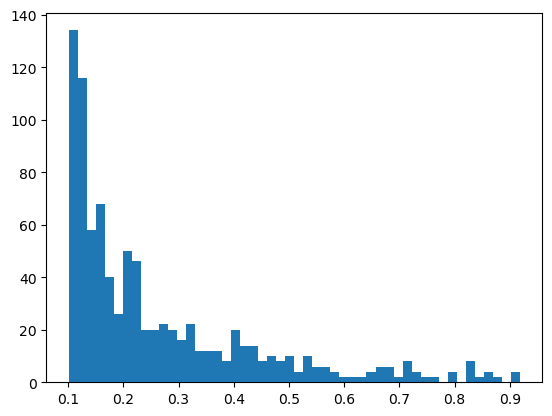

In [13]:
plt.hist(ae_sim.flatten()[ae_sim.flatten() > .1], bins=50);

### TSNE

In [14]:
# adjust spatial scaling in dataframe construction cell above
tsne = TSNE(n_components = 2)
lat_tsne = tsne.fit_transform(lat_dist)

ae_df['tsne_1'] = lat_tsne[:train_lat_peak.shape[0],0]
ae_df['tsne_2'] = lat_tsne[:train_lat_peak.shape[0],1]
mean_tsne = lat_tsne[train_lat_peak.shape[0]:]

In [15]:
colors = ["#000000","#FFFF00","#1CE6FF","#FF34FF","#FF4A46","#008941","#006FA6","#A30059","#FFDBE5","#7A4900","#0000A6","#63FFAC","#B79762","#004D43","#8FB0FF","#997D87","#5A0007","#809693","#FEFFE6","#1B4400","#4FC601","#3B5DFF","#4A3B53","#FF2F80","#61615A","#BA0900","#6B7900","#00C2A0","#FFAA92","#FF90C9","#B903AA","#D16100","#DDEFFF","#000035","#7B4F4B","#A1C299","#300018","#0AA6D8","#013349","#00846F","#372101","#FFB500","#C2FFED","#A079BF","#CC0744","#C0B9B2","#C2FF99","#001E09","#00489C","#6F0062","#0CBD66","#EEC3FF","#456D75","#B77B68","#7A87A1","#788D66","#885578","#FAD09F","#FF8A9A","#D157A0","#BEC459","#456648","#0086ED","#886F4C","#34362D","#B4A8BD","#00A6AA","#452C2C","#636375","#A3C8C9","#FF913F","#938A81","#575329","#00FECF","#B05B6F","#8CD0FF","#3B9700","#04F757","#C8A1A1","#1E6E00","#7900D7","#A77500","#6367A9","#A05837","#6B002C","#772600","#D790FF","#9B9700","#549E79","#FFF69F","#201625","#72418F","#BC23FF","#99ADC0","#3A2465","#922329","#5B4534","#FDE8DC","#404E55","#0089A3","#CB7E98","#A4E804","#324E72","#6A3A4C","#83AB58","#001C1E","#D1F7CE","#004B28","#C8D0F6","#A3A489","#806C66","#222800","#BF5650","#E83000","#66796D","#DA007C","#FF1A59","#8ADBB4","#1E0200","#5B4E51","#C895C5","#320033","#FF6832","#66E1D3","#CFCDAC","#D0AC94","#7ED379","#012C58","#7A7BFF","#D68E01","#353339","#78AFA1","#FEB2C6","#75797C","#837393","#943A4D","#B5F4FF","#D2DCD5","#9556BD","#6A714A","#001325","#02525F","#0AA3F7","#E98176","#DBD5DD","#5EBCD1","#3D4F44","#7E6405","#02684E","#962B75","#8D8546","#9695C5","#E773CE","#D86A78","#3E89BE","#CA834E","#518A87","#5B113C","#55813B","#E704C4","#00005F","#A97399","#4B8160","#59738A","#FF5DA7","#F7C9BF","#643127","#513A01","#6B94AA","#51A058","#A45B02","#1D1702","#E20027","#E7AB63","#4C6001","#9C6966","#64547B","#97979E","#006A66","#391406","#F4D749","#0045D2","#006C31","#DDB6D0","#7C6571","#9FB2A4","#00D891","#15A08A","#BC65E9","#C6DC99","#203B3C","#671190","#6B3A64","#F5E1FF","#FFA0F2","#CCAA35","#374527","#8BB400","#797868","#C6005A","#3B000A","#C86240","#29607C","#402334","#7D5A44","#CCB87C","#B88183","#AA5199","#B5D6C3","#A38469","#9F94F0","#A74571","#B894A6","#71BB8C","#00B433","#789EC9","#6D80BA","#953F00","#5EFF03","#E4FFFC","#1BE177","#BCB1E5","#76912F","#003109","#0060CD","#D20096","#895563","#29201D","#5B3213","#A76F42","#89412E","#1A3A2A","#494B5A","#A88C85","#F4ABAA","#A3F3AB","#00C6C8","#EA8B66","#958A9F","#BDC9D2","#9FA064","#BE4700","#658188","#83A485","#453C23","#47675D","#3A3F00","#061203","#DFFB71","#868E7E","#98D058","#6C8F7D","#D7BFC2","#3C3E6E","#D83D66","#2F5D9B","#6C5E46","#D25B88","#5B656C","#00B57F","#545C46","#866097","#365D25","#252F99","#00CCFF","#674E60","#FC009C","#92896B"]

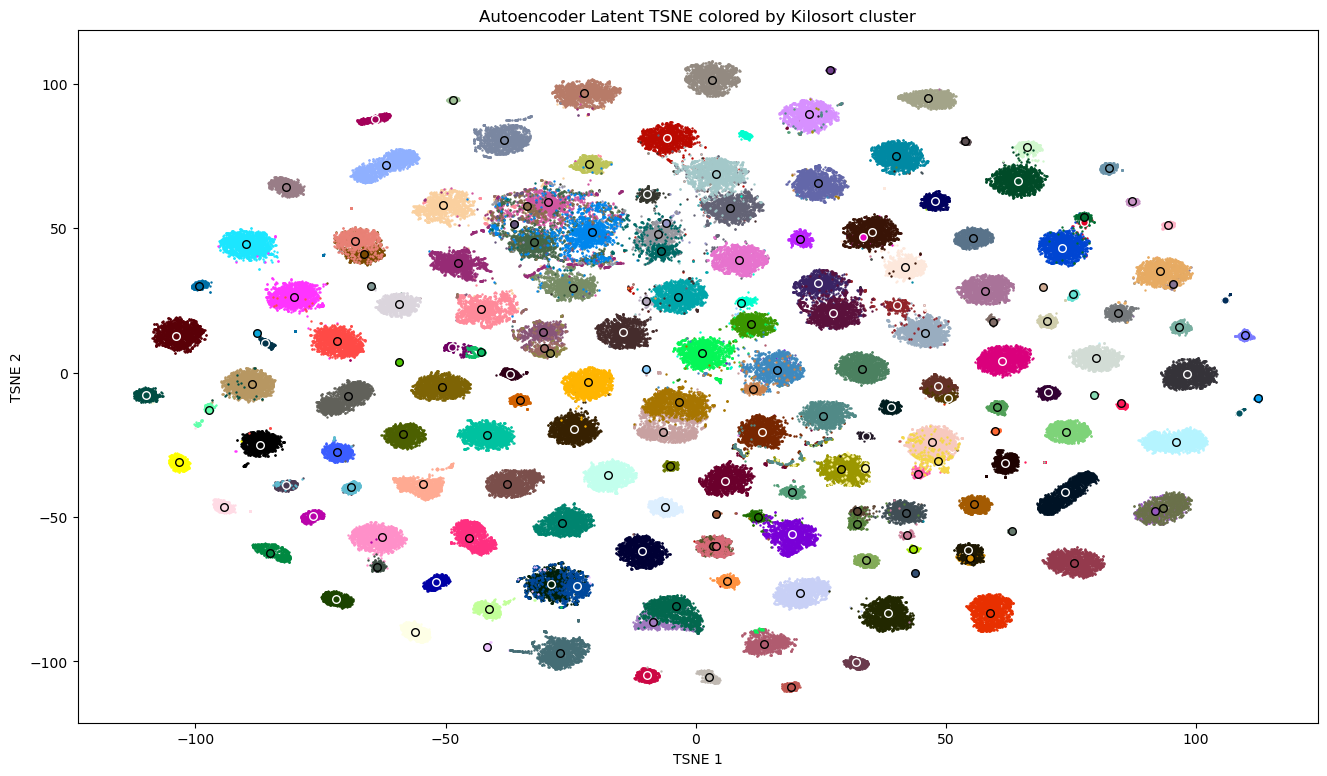

In [21]:
plt.figure(figsize=(16,9))

# spikes
ind = 0
for group in ae_df.groupby('cl'):
    plt.scatter(group[1]['tsne_1'],group[1]['tsne_2'], s=0.5, label=ind, color=colors[ind], alpha=1); 
    ind += 1

# centroid
ind = 0

for group in ae_df.groupby('cl'):
    # luminance calculation to pick edge color
    h = colors[ind].lstrip("#")
    r,g,b = tuple(int(h[i:i+2], 16) for i in (0, 2, 4))
    lum = 0.2126*r + 0.7152*g + 0.0722*b
    edgecolor = 'black' if lum > 70 else 'white'

    plt.scatter(mean_tsne[int(group[0]), 0], mean_tsne[int(group[0]), 1], color=colors[ind], s=30, edgecolor=edgecolor, marker='o')
    ind += 1
        
plt.xlabel("TSNE 1"); plt.ylabel("TSNE 2"); plt.title("Autoencoder Latent TSNE colored by Kilosort cluster");